In [53]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
from tqdm import tqdm

In [54]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [55]:
def sm_loss(params, samples):

    mu = params["mu"]
    L = params["L"]
    prec = L @ L.T

    centered = samples - mu
    prec2 = prec @ prec
    quad_terms = jnp.sum((centered @ prec2) * centered, axis=1)

    loss = 0.5 * jnp.mean(quad_terms) - jnp.trace(prec)
    
    return loss

In [56]:
def optimize_score_matching_with_tracking(samples, true_mu, true_cov, n_steps=1000, lr=1e-2, seed=0):
    d = samples.shape[1]
    key = jax.random.PRNGKey(seed)
    key_mu, key_L = jax.random.split(key)

    mu_init = jax.random.normal(key_mu, shape=(d,))
    L_init = jnp.eye(d) + 0.01 * jax.random.normal(key_L, shape=(d, d))
    L_init = jnp.tril(L_init)

    params = {"mu": mu_init, "L": L_init}
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    loss_grad_fn = jax.value_and_grad(sm_loss)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_l2": [],
        "cov_fro": [],
    }

    for step in range(n_steps):
        loss_val, grads = loss_grad_fn(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        params["L"] = jnp.tril(params["L"])  # keeping L lower-triangular

        # tracking
        mu_hat = params["mu"]
        prec_hat = params["L"] @ params["L"].T
        cov_hat = jnp.linalg.inv(prec_hat)

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_hat))
        history["cov_l2"].append(jnp.linalg.norm(true_cov - cov_hat, ord=2))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_hat, ord='fro'))

    return params, history

In [57]:
mu = jnp.array([0.0])

cov = jnp.array([
[1.0]
])

In [58]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

params_hat, history = optimize_score_matching_with_tracking(samples, mu, cov, n_steps=300, lr=1e-2, seed = 0)

mu_hat = params_hat["mu"]
precision_hat = params_hat["L"] @ params_hat["L"].T
cov_hat = jnp.linalg.inv(precision_hat)

In [59]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(mu_hat, 4), jnp.linalg.norm(mu - mu_hat), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(cov_hat, 4), jnp.linalg.norm(cov - cov_hat), "\n\n\n")

[0.] 

 [-0.0223] 0.022346364 



[[1.]] 

 [[1.0069]] 0.0069032907 





In [60]:
history_np = {k: np.array(v) for k, v in history.items()}

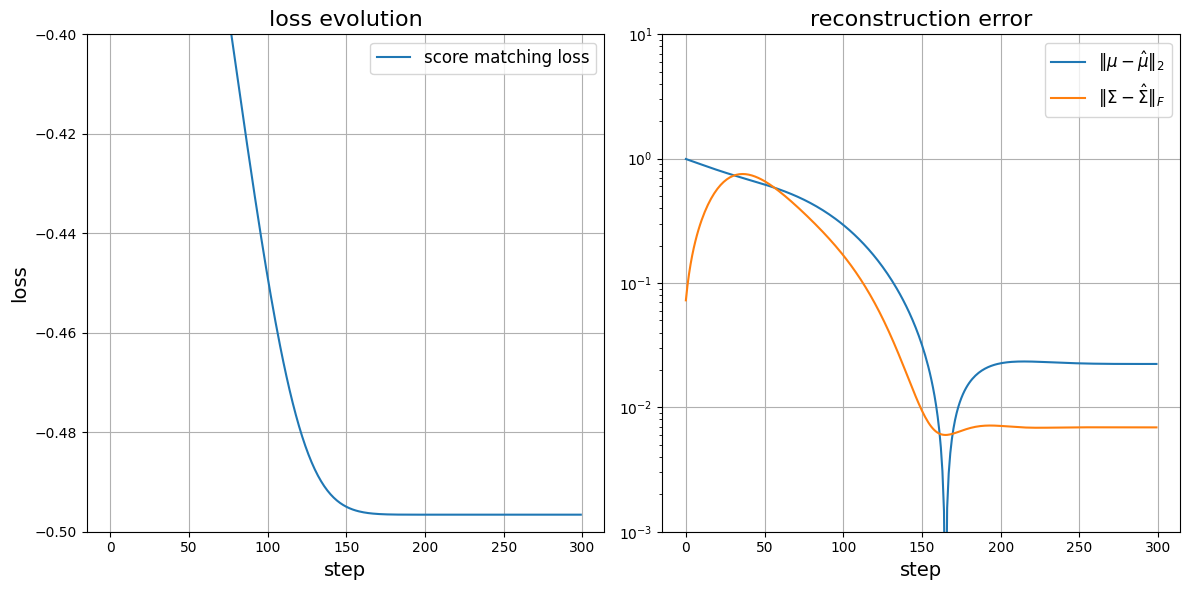

In [61]:
ymin_recon = -0.5
ymax_recon = -0.4
plt.figure(figsize=(12, 6))

# Primo plot: loss
plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.ylim(ymin_recon, ymax_recon)
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)

# Secondo plot: reconstruction error
ymin_recon = 1e-3
ymax_recon = 10.0
plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.ylim(ymin_recon, ymax_recon)
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)

# Migliora layout e mostra
plt.tight_layout()
plt.show()

In [62]:
history_np["mu_l2"]

array([0.994 , 0.984 , 0.9741, 0.9642, 0.9543, 0.9445, 0.9347, 0.9251,
       0.9155, 0.9061, 0.8967, 0.8875, 0.8784, 0.8694, 0.8605, 0.8518,
       0.8432, 0.8348, 0.8265, 0.8184, 0.8104, 0.8026, 0.7949, 0.7873,
       0.7799, 0.7726, 0.7655, 0.7585, 0.7516, 0.7449, 0.7382, 0.7317,
       0.7253, 0.7189, 0.7127, 0.7065, 0.7004, 0.6944, 0.6885, 0.6826,
       0.6768, 0.671 , 0.6652, 0.6595, 0.6538, 0.6481, 0.6425, 0.6368,
       0.6312, 0.6256, 0.6199, 0.6143, 0.6086, 0.6029, 0.5972, 0.5915,
       0.5857, 0.5799, 0.5741, 0.5682, 0.5623, 0.5563, 0.5503, 0.5443,
       0.5382, 0.532 , 0.5258, 0.5196, 0.5133, 0.5069, 0.5005, 0.4941,
       0.4876, 0.481 , 0.4744, 0.4678, 0.4611, 0.4544, 0.4476, 0.4408,
       0.4339, 0.4271, 0.4201, 0.4132, 0.4062, 0.3992, 0.3922, 0.3852,
       0.3781, 0.3711, 0.364 , 0.3569, 0.3498, 0.3427, 0.3356, 0.3286,
       0.3215, 0.3145, 0.3074, 0.3004, 0.2934, 0.2864, 0.2795, 0.2726,
       0.2657, 0.2589, 0.2521, 0.2453, 0.2386, 0.232 , 0.2254, 0.2189,
      

In [63]:
history_np["cov_fro"]

array([0.0726, 0.0951, 0.1182, 0.1419, 0.1661, 0.1909, 0.2161, 0.2417,
       0.2677, 0.2939, 0.3203, 0.3467, 0.3732, 0.3995, 0.4257, 0.4514,
       0.4768, 0.5015, 0.5256, 0.5489, 0.5713, 0.5927, 0.613 , 0.6321,
       0.65  , 0.6665, 0.6816, 0.6953, 0.7076, 0.7184, 0.7276, 0.7354,
       0.7417, 0.7466, 0.75  , 0.7521, 0.7528, 0.7522, 0.7505, 0.7476,
       0.7436, 0.7385, 0.7326, 0.7257, 0.7181, 0.7097, 0.7007, 0.6911,
       0.6809, 0.6703, 0.6592, 0.6478, 0.6361, 0.6242, 0.6121, 0.5998,
       0.5874, 0.575 , 0.5625, 0.55  , 0.5375, 0.5251, 0.5127, 0.5005,
       0.4883, 0.4763, 0.4645, 0.4528, 0.4412, 0.4298, 0.4187, 0.4077,
       0.3969, 0.3863, 0.3758, 0.3656, 0.3556, 0.3458, 0.3362, 0.3267,
       0.3175, 0.3084, 0.2996, 0.2909, 0.2824, 0.274 , 0.2658, 0.2578,
       0.25  , 0.2423, 0.2348, 0.2274, 0.2201, 0.213 , 0.2061, 0.1992,
       0.1926, 0.186 , 0.1796, 0.1733, 0.1671, 0.161 , 0.1551, 0.1493,
       0.1436, 0.138 , 0.1326, 0.1273, 0.122 , 0.117 , 0.112 , 0.1071,
      

100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


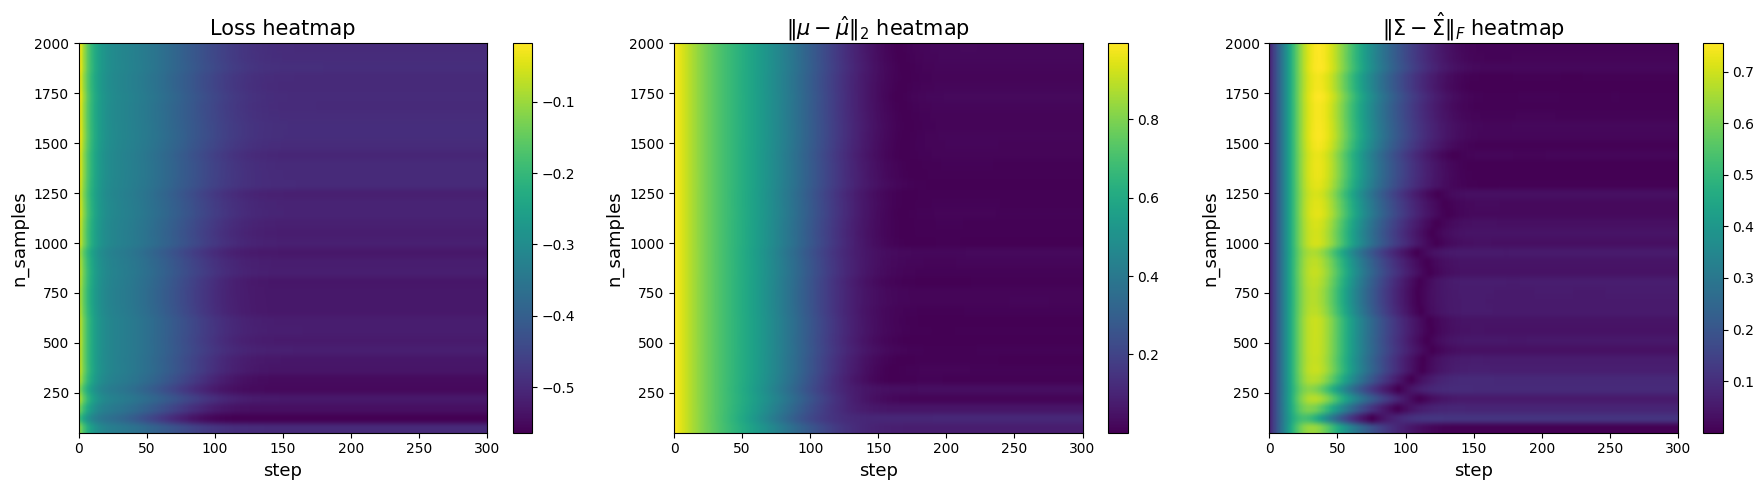

In [64]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 300

all_losses = []
all_mu_errors = []
all_cov_errors = []

for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, history = optimize_score_matching_with_tracking(samples, mu, cov, n_steps=n_steps)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

# === plotting ===

import matplotlib.pyplot as plt

# Convertiamo i dati in array NumPy (se non già)
loss_matrix = np.array(all_losses)         # shape: (n_sample_sizes, n_steps)
mu_err_matrix = np.array(all_mu_errors)    # shape: (n_sample_sizes, n_steps)
cov_err_matrix = np.array(all_cov_errors)  # shape: (n_sample_sizes, n_steps)

# Assi
steps = np.linspace(0, n_steps, n_steps)  # o np.arange(1, n_steps + 1)
sample_sizes = np.arange(50, 2001, 50)

# Funzione per un singolo heatmap
def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)

# Plot multiplo
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")

plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2$ heatmap", "n_samples")

plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F$ heatmap", "n_samples")

plt.tight_layout()
plt.show()

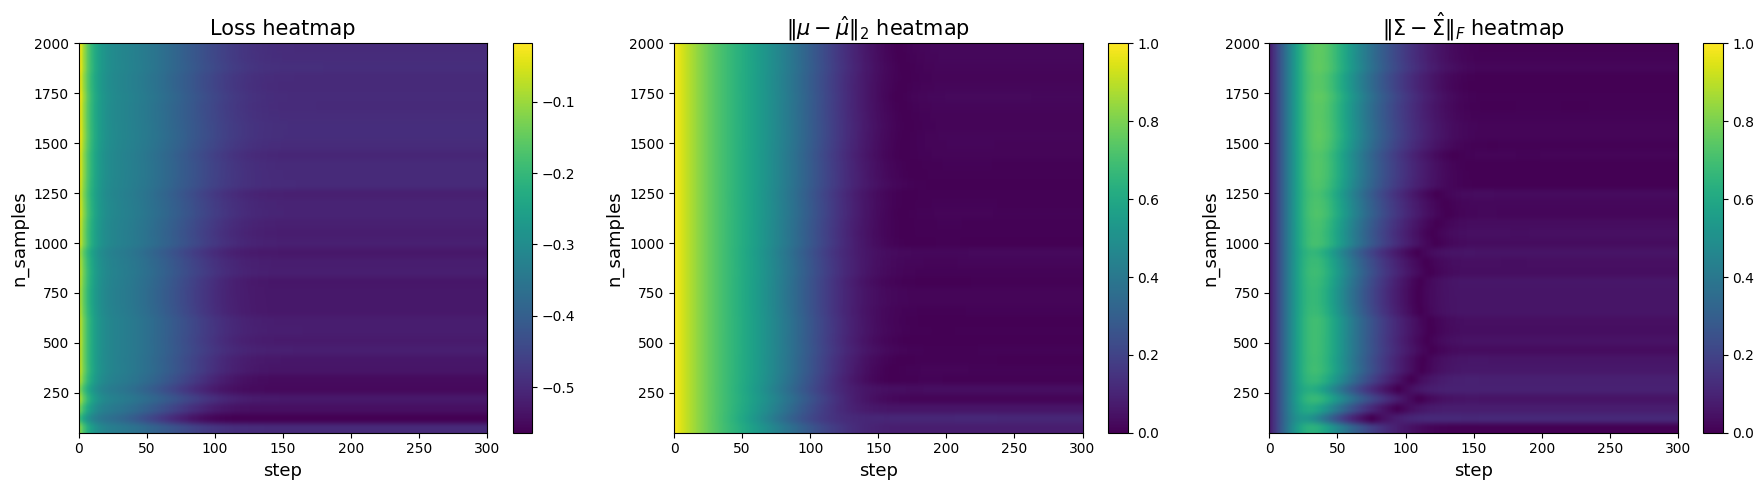

In [66]:

# Convertiamo i dati in array NumPy (se non già)
loss_matrix = np.array(all_losses)         # shape: (n_sample_sizes, n_steps)
mu_err_matrix = np.array(all_mu_errors)    # shape: (n_sample_sizes, n_steps)
cov_err_matrix = np.array(all_cov_errors)  # shape: (n_sample_sizes, n_steps)

# Assi
steps = np.linspace(0, n_steps, n_steps)  # o np.arange(1, n_steps + 1)
sample_sizes = np.arange(50, 2001, 50)

# Funzione per un singolo heatmap
def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)

# Plot multiplo
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")

plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)

plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)

plt.tight_layout()
plt.show()